In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
import xarray
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from davitpy import utils
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,6,8)
timeStart = datetime.datetime(2011,6,8,4,0)
selTime = datetime.datetime(2011,6,8,4,34) 
timeEnd = datetime.datetime(2011,6,8,6,0)
azimCutoff = 30.
plotMlatRange = [ 55., 70. ]
velScale = [ 0., 500. ]
saisVelCutoff = 150.
# Plotting SAPS vels arrows
arrowLenFactor = 8
coords = "mlt"

In [3]:
ampSCWDF = feather.read_dataframe('../data/amp-scw-' +\
                eventDate.strftime("%Y%m%d") + '.feather')

In [4]:
# read from the feather file
fitsDF = feather.read_dataframe('../data/lshell-fits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
# set a few filters to the data
# 1) azim should be -90+/-cutoff
# fitsDF = fitsDF[ numpy.abs( fitsDF["azimSAPS"] ) < azimCutoff ]
# Calculate details for plotting arrows
# We plot the arrows on the time axis, so instead of normMLT
# we'll use time to estimate the end points of the vectors!
fitsDF["time"] = fitsDF["date"].map(lambda x:(x.hour + x.minute/60.)*arrowLenFactor)
# Need three MLATs (min, med and max) if you we want to plot
# the latitudinal extent of the flows!
fitsDF["endPtMedMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["medLat"], 2)
fitsDF["endPtMinMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["minLat"], 2)
fitsDF["endPtMaxMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["maxLat"], 2)
# We can have just one MLT
fitsDF["endPtTime"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) *\
             numpy.sin( numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) )\
              + fitsDF["time"], 2)
fitsDF.head()

,azimSAPS,azimSTD,date,maxLat,maxMLT,medLat,medMLT,minLat,minMLT,mltSAPS,velSAPS,velSTD,time,endPtMedMLAT,endPtMinMLAT,endPtMaxMLAT,endPtTime
0,91.358937,11.594226,2011-06-08 04:08:00,60.8178,0.3144,59.80970,-0.06940,58.2897,-0.4926,-0.0,147.448774,15.983333,33.066667,59.66,58.14,60.67,33.07
1,76.180049,15.134774,2011-06-08 04:10:00,60.6539,0.3130,59.55330,-0.02685,57.8124,-0.4658,-0.0,131.666966,9.778961,33.333333,59.43,57.68,60.53,33.30
2,77.415258,16.457594,2011-06-08 04:12:00,60.5115,0.3458,59.42270,-0.00390,57.7129,-0.4512,-0.0,131.454290,11.295993,33.600000,59.29,57.58,60.38,33.57
3,56.153828,20.690777,2011-06-08 04:14:00,60.6539,0.4822,59.38305,0.03895,57.7129,-0.4181,-0.0,159.251063,13.998339,33.866667,59.25,57.58,60.52,33.78
4,71.456240,19.837697,2011-06-08 04:16:00,60.6539,0.4802,59.32195,0.09470,57.5378,-0.3853,-0.0,174.530629,15.721137,34.133333,59.16,57.37,60.49,34.08


In [5]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
#     ax2.set_ylim(miny+dy, maxy+dy)


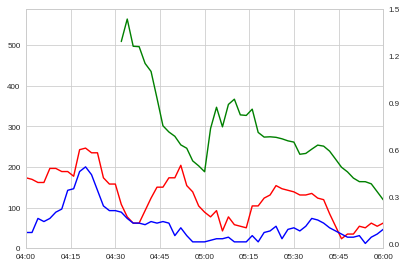

In [6]:
# Select MLTs to plot
pltNormMLT = -2.
if pltNormMLT < 0:
    pltMLT = pltNormMLT + 24.
else:
    pltMLT = pltNormMLT
plotSCWDF = fitsDF[ fitsDF["mltSAPS"] == pltNormMLT ]
plotAmpDF = ampSCWDF[ ampSCWDF["scwMLTDown"] == pltMLT ]
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
# Plot the data
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax2 = ax.twinx()

ax.plot( plotSCWDF["date"].values, plotSCWDF["velSAPS"].values, 'g' )
# ax.plot( plotSCWDF["date"].values, plotSCWDF["velSAPS"].values, 'o' )
ax2.plot( plotAmpDF['scwLocDates'].values, plotAmpDF['scwJrUp'].values, 'r' )
ax2.plot( plotAmpDF['scwLocDates'].values, numpy.abs(plotAmpDF['scwJrDown'].values), 'b' )
# ax2.axis('off')
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


ax.set_yticks(numpy.linspace(0,500, 6))
ax2.set_yticks(numpy.linspace(0,1.5, 6))
# align_yaxis(ax, 0, ax2, 0)
ax2.grid('off')

ax.set_xlim( [ timeStart, timeEnd ] )
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

fig1.savefig("../plots/vels-amp-ts-20110608.pdf",bbox_inches='tight')

In [7]:
# Read AMPERE data
ampFName = "../data/" + eventDate.strftime("%Y%m%d") + ".0000.86400.120.north.grd.ncdf"
dsXarr = xarray.open_dataset(ampFName)
ampDF = dsXarr.to_dataframe()
ampDF["start_date"] = pandas.to_datetime( dict(year=ampDF.start_yr,\
                    month=ampDF.start_mo, day=ampDF.start_dy,\
                    hour=ampDF.start_hr, minute=ampDF.start_mt,\
                    second=ampDF.start_sc))
ampDF["end_date"] = pandas.to_datetime( dict(year=ampDF.end_yr,\
                    month=ampDF.end_mo, day=ampDF.end_dy,\
                    hour=ampDF.end_hr, minute=ampDF.end_mt,\
                    second=ampDF.end_sc))
ampDF["mlat"] = 90. - ampDF["colat"]
selCols = ['start_date', 'end_date', 'mlat',\
           'mlt', 'dBnorth1', 'dBeast1',\
       'dBnorth2', 'dBeast2', 'dBr', 'Jr']
ampDF = ampDF[selCols].reset_index(drop=True)

ampDF.head()

,start_date,end_date,mlat,mlt,dBnorth1,dBeast1,dBnorth2,dBeast2,dBr,Jr
0,2011-06-08,2011-06-08 00:10:00,89.0,0.0,147.089996,30.629999,143.679993,43.900002,29.889999,-0.02
1,2011-06-08,2011-06-08 00:10:00,88.0,0.0,159.339996,31.719999,154.250000,51.009998,24.180000,-0.09
2,2011-06-08,2011-06-08 00:10:00,87.0,0.0,158.559998,25.010000,153.210007,47.889999,4.960000,-0.13
3,2011-06-08,2011-06-08 00:10:00,86.0,0.0,140.130005,15.470000,135.770004,37.970001,-23.920000,-0.13
4,2011-06-08,2011-06-08 00:10:00,85.0,0.0,111.970001,5.390000,109.360001,24.600000,-53.520000,-0.12


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


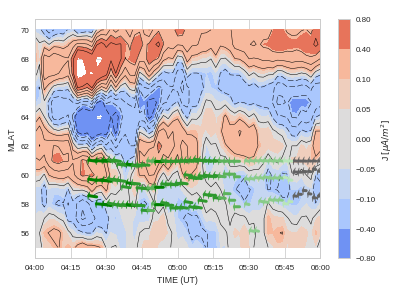

In [8]:
# Some temp constants
plotMltChsn = 21
if plotMltChsn > 12:
    pltNormMLTChsn = plotMltChsn - 24.
else:
    pltNormMLTChsn = plotMltChsn
plotJrCutoff = 0.
plotJrMin = -0.4
plotJrMax = 0.4
ticks = [ -0.8, -0.4, -0.1, -0.05, 0, 0.05, 0.1, 0.4, 0.8 ]
colNorm = Normalize( vmin=velScale[0], vmax=velScale[1] )
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plotting
seaMap = ListedColormap(sns.color_palette("coolwarm",11))

sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = ampDF[ ((ampDF["start_date"] >= timeStart) & (ampDF["start_date"] <= timeEnd) &\
                    (ampDF["mlt"] == plotMltChsn) & (numpy.abs(ampDF["Jr"])>=plotJrCutoff) &\
              (ampDF["mlat"] >= plotMlatRange[0]) & (ampDF["mlat"] <= plotMlatRange[1]) )]
selMltFitsDF = fitsDF[ fitsDF["mltSAPS"] == pltNormMLTChsn ]


selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]
plotAmpDF = selDF[ ["mlat", "time",\
                        "Jr"] ].pivot( "mlat", "time" )
mlatVals = plotAmpDF.index.values
timeVals = plotAmpDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
jrVals = numpy.ma.masked_where(numpy.isnan(plotAmpDF["Jr"].values),plotAmpDF["Jr"].values)
ampPlot = ax.contourf(timeCntr, mlatCntr,jrVals.T, ticks,cmap=seaMap)
ax.contour(timeCntr, mlatCntr,jrVals.T, numpy.linspace(-0.5, 0.5, 9),
                 origin='lower',
                 linewidths=0.5,colors='k')
cbar = plt.colorbar(ampPlot)
cbar.set_label(r"J $ [\mu A/m^{2}]$")

ax.set_xticks(xTickList)

ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# Plot SD data
velColors = [ "#feebe2", "#fbb4b9", "#f768a1", "#c51b8a", "#7a0177" ]
# ax.scatter( selMltFitsDF["date"].values, selMltFitsDF["medLat"].values,\
#            c=selMltFitsDF["velSAPS"].values, s=selMltFitsDF["velSAPS"].values/3.,\
#           cmap=ListedColormap(sns.light_palette("Purple")), alpha=0.75)

ax.set_xlim( [timeStart, timeEnd] )
ax.set_ylim( plotMlatRange )

ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
seaMap = ListedColormap( sns.light_palette("green") )
ax2 = ax.twiny()
for index, row in selMltFitsDF.iterrows():
    currCol = seaMap( colNorm(row['velSAPS']) )
    if row['velSAPS'] < saisVelCutoff:
        currCol = "#636363"
    # Min Lat Loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["minLat"],\
                row['endPtMinMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["minLat"], row["endPtTime"]-row["time"], row['endPtMinMLAT']-row["minLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
    # Median Lat Loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["medLat"],\
                row['endPtMedMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["medLat"], row["endPtTime"]-row["time"], row['endPtMedMLAT']-row["medLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
    # Max Lat loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["maxLat"],\
                row['endPtMaxMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["maxLat"], row["endPtTime"]-row["time"], row['endPtMaxMLAT']-row["maxLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
# Need to carefully set the x-axis
ax2.set_xlim([(timeStart.hour + timeStart.minute/60.)*arrowLenFactor,\
              (timeEnd.hour + timeEnd.minute/60.)*arrowLenFactor])
ax2.axis('off')

fig.savefig( "../plots/sapsSCW-20110608.pdf",bbox_inches='tight' )